# Imports

First we import the discrete GRN dependencies.

In [1]:
from discrete_motif import DiscreteGrnMotif
import discrete_motif_functions as functions
import discrete_motif_operations as operations
import discrete_motif_measures as measures
import discrete_motif_generator as generator
import discrete_motif_plotting as visualize
from IPython.display import HTML, display
import tabulate

# Data imports

# Experiments

## Correlation between synergy and nudge resilience in a truly random motif

First, we generate 50 random motifs of size 3. We use the WMS synergy, which is an upper bound.

The states: 
[[[ 0.00847309  0.04532879  0.04241946]
  [ 0.0023596   0.03422888  0.07942223]
  [ 0.01627753  0.00517175  0.00072841]]

 [[ 0.04281796  0.05268549  0.07728813]
  [ 0.01960101  0.03328322  0.07699172]
  [ 0.07031557  0.02007556  0.06943655]]

 [[ 0.07527615  0.02350997  0.01395048]
  [ 0.01540188  0.02182344  0.04550211]
  [ 0.02342486  0.01151481  0.07269137]]]
[[[ 0.0  0.023509971  0.036588479]
  [ 0.0  0.0  0.0]
  [ 0.0  0.0051717464  0.086790962]]

 [[ 0.0  0.0084730864  0.045502109]
  [ 0.023424857  0.016277526  0.072761049]
  [ 0.2424266  0.0  0.019601012]]

 [[ 0.072691366  0.08571745  0.00072840934]
  [ 0.013950483  0.17694835  0.0]
  [ 0.0  0.0  0.069436545]]]
The correlations: 
[[  6.92178365e-310   9.62146177e-001  -1.33498931e-002]
 [  9.62146177e-001   6.92177814e-310  -1.38751194e-002]
 [ -1.33498931e-002  -1.38751194e-002   3.95252517e-322]]
Transitions: 
[[0 0 0 1 0 1]
 [0 0 1 1 2 0]
 [0 0 2 2 1 1]
 [0 1 0 0 0 2]
 [0 1 1 0 0 2]
 [0 1 2 2 1 1]
 [0 2 0 1 1 1

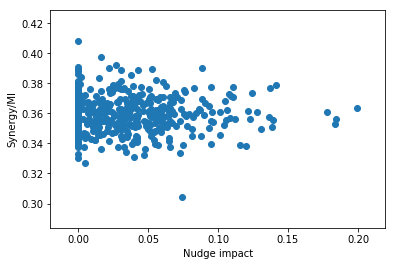

In [2]:
# create a network motif
motifs = generator.generate_random(samplesize=500, no_nodes=3, numvalues=3)

# let's check the first one out
motif_rand = motifs[0]
motif_rand.evaluate_motif()
print("The states: ")
for state in motif_rand.states:
    print(state)
print("The correlations: ")
print(motif_rand.grn_vars["correlations"])
print("Transitions: ")
print(motif_rand.transition_table)

# make a plot with WMS synergy
visualize.scatterplot_synergy_nudgeimpact(motifs, 3, 0.5, measures.synergy_middleground)

# Experiments

## Correlation between synergy and nudge resilience in biological random motif

We use the middle between the  WMS synergy, which is a lower bound, and the maximum individiual MI, which is an upper bound.

average indegree is 3.062
failed to find the synergy
failed to find the synergy
failed to find the synergy


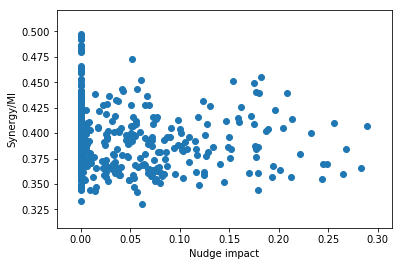

In [3]:
# create a network motif
motifs, indegree_avg = generator.generate_motifs(samplesize=500, no_nodes=3, numvalues=3, conflict_rule='totaleffect')
print("average indegree is "+str(indegree_avg))

# make a plot with WMS synergy
visualize.scatterplot_synergy_nudgeimpact(motifs, 3, 0.5, measures.synergy_middleground)

In [ ]:
# create a network motif
motifs, indegree_avg = generator.generate_motifs(samplesize=500, no_nodes=3, numvalues=3, conflict_rule='totaleffect')
print("average indegree is "+str(indegree_avg))

# make a plot with WMS synergy
visualize.scatterplot_synergy_nudgeimpact(motifs, 3, 0.5, measures.synergy_middleground)

In [ ]:
# create a network motif
#motifs, indegree_avg = generator.generate_motifs(samplesize=1, no_nodes=3, numvalues=5, conflict_rule='totaleffect')
#print("average indegree is "+str(indegree_avg))

# make a plot with WMS synergy
#visualize.scatterplot_synergy_nudgeimpact(motifs, 3, 0.5, measures.synergy_quax)

## More synergy in biological motif than in random

## Real GRN motif scores better than a random motif in memory

## Real GRN motif scores better than a random motif in single nudge resilience

## Real GRN motif scores similar to random motif in multiple nudge resilience

## There is a stronger than linear decrease in resilience when increasing the number of variables nudged in a biological GRN motif